In [1]:
import numpy as np
import pylab as pl
import scipy.fftpack as ff
import h5py
from scipy import interpolate

In [2]:
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'medium'

pl.rcParams['xtick.major.size'] = 8
pl.rcParams['xtick.minor.size'] = 4
pl.rcParams['xtick.major.pad']  = 8
pl.rcParams['xtick.minor.pad']  = 8
pl.rcParams['xtick.color']      = 'k'
pl.rcParams['xtick.labelsize']  = 'medium'
pl.rcParams['xtick.direction']  = 'in'

pl.rcParams['ytick.major.size'] = 8
pl.rcParams['ytick.minor.size'] = 4
pl.rcParams['ytick.major.pad']  = 8
pl.rcParams['ytick.minor.pad']  = 8
pl.rcParams['ytick.color']      = 'k'
pl.rcParams['ytick.labelsize']  = 'medium'
pl.rcParams['ytick.direction']  = 'in'

### For reference
\begin{align}
\hat{V}(k) &= \int_{0}^{1} V(x)e^{-2\pi\;i\;k\;x}dx \\ \\
V(x) &= \frac{1}{Npoints}\int_{0}^{1} \hat{V}(k)e^{+2\pi\;i\;k\;x}dk \\ \\
\hat{V}(k) &= \frac{1}{4\pi^{2}\;k^2}\hat{\rho(k)} \\ \\
\hat{E}(k) &= -i(2\pi\;k)\hat{V}(k)
\end{align}

In [3]:
# FFT solver :
def fft_poisson(rho,dx):

    kspace = ff.fftfreq(len(rho), d = dx)
    rho_kspace = ff.fft(rho)

    V_kspace = np.zeros(len(rho))
    
    V_kspace[1:] =  (1/(4 * np.pi**2 * kspace[1:]**2)) * rho_kspace[1:]
    V_kspace[0]  =  (1/(4 * np.pi**2)) * np.sum(rho)/(len(rho)) 
    
    E_kspace =  -1j * 2 * np. pi * kspace * V_kspace
    
    V = ff.ifft(V_kspace)

    V = V.astype(np.double)
    
    E = ff.ifft(E_kspace)
    
    E = E.astype(np.double)
    
    return V, E

In [4]:
# b1 charge depositor
def cloud_charge_deposition(charge, zone_x, frac_x, x_grid, dx):

    left_corner_charge = (1 - frac_x) * charge / (dx)
    right_corner_charge = (frac_x) * charge / (dx)

    left_corners  = zone_x.copy()
    right_corners = left_corners + 1

    corners = np.concatenate([left_corners, right_corners], axis=0)
    charges = np.concatenate([left_corner_charge, right_corner_charge], axis=0)

    rho, temp = np.histogram(corners, bins=len(x_grid), range=(0, len(x_grid)), weights=charges)

    return rho

In [5]:
k_boltzmann     = 1
mass_electron   = 1
tempertature    = 1
charge_electron = -1
charge_ion      = +1

In [6]:
length_domain_x = 1

In [7]:
number_of_electrons = 500000

positions_x = length_domain_x * np.random.rand(number_of_electrons)

mu, sigma = 0, (k_boltzmann * tempertature / mass_electron)

velocity_x = np.random.normal(mu, sigma, number_of_electrons)

In [8]:
divisions_domain_x = 100

x_grid = np.linspace(0, length_domain_x, divisions_domain_x + 1, endpoint=True)

dx = x_grid[1] - x_grid[0]

In [9]:
# Setting the amplitude for perturbation
Amplitude_perturbed = 0.05
k_fourier = 2 * np.pi
# Initializing the perturbation

x_divisions_perturbed = 100
positions_x = np.zeros(number_of_electrons)
velocity_x  = np.zeros(number_of_electrons)
last=0
next=0

for i in range(x_divisions_perturbed):
    next=last+(number_of_electrons*Amplitude_perturbed*np.sin((np.pi/2)+i*k_fourier*length_domain_x/x_divisions_perturbed)/x_divisions_perturbed)+(number_of_electrons/x_divisions_perturbed)
    number = len(positions_x[int(round(last)):(int(round(next))-1)])
    positions_x[int(round(last)):(int(round(next))-1)] = length_domain_x*(i+1)/(x_divisions_perturbed+1)
    n_temp = (1 + Amplitude_perturbed * np.cos(i*k_fourier*length_domain_x/x_divisions_perturbed))
    velocity_x[int(round(last)):(int(round(next))-1)] = n_temp * np.random.normal(mu, sigma, number)
    last=next

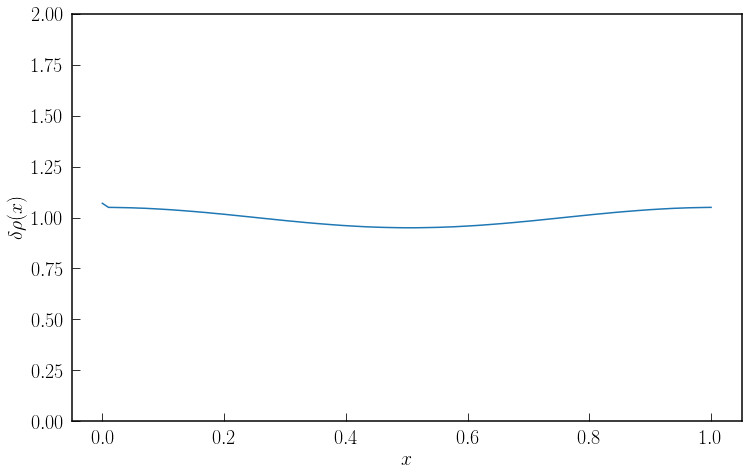

In [10]:
# positions_x = np.sin(np.pi * positions_x) 
# Plot
x_temp = np.linspace(0,1,100)
a, b = np.histogram(positions_x, bins=(divisions_domain_x), range=(0, length_domain_x))
a = (a / (number_of_electrons / divisions_domain_x))
pl.plot(x_temp,a)
pl.xlabel('$x$')
pl.ylabel(r'$\delta\rho(x)$')
pl.ylim(0.0,2.0)
# pl.savefig('data_files/images/' + '%04d'%(0) + '.png')
pl.show()
pl.clf()

In [11]:
start_time = 0

end_time   = 3

dt  = 0.001

time = np.arange(start_time, end_time + dt, dt)

In [12]:
rho_ions = (charge_ion * number_of_electrons) / (len(x_grid) * dx)

In [13]:
Ex_all_times = np.zeros((len(time)/10) + 1)
Ex_max = np.zeros((len(time)/10) + 1)

/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':
/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app


In [14]:
for time_index in range(len(time)):
    if(time_index%100==0):
        print('Computing for time_index = ', time_index)
        
    # Updating the positions of particle
    
    positions_x += velocity_x * dt

    # Boundary conditions for particles
    
    outside_domain = np.where([positions_x < 0])[1]
    
    positions_x[outside_domain] = positions_x[outside_domain] + length_domain_x

    outside_domain = np.where([positions_x > length_domain_x])[1]
    
    positions_x[outside_domain] -= length_domain_x

    # Finding interpolant fractions for the positions

    zone_x = np.floor(((positions_x - x_grid[0]) / dx))
    zone_x = zone_x.astype(np.int)
    frac_x = (positions_x - x_grid[zone_x]) / (dx)

    # Charge deposition using linear weighting scheme

    rho = cloud_charge_deposition(charge_electron, zone_x, frac_x, x_grid, dx)
    rho+= rho_ions
    rho = rho/ number_of_electrons
    
    # Calculating the potential/Electric field from the charge deposition.

    V, Ex = fft_poisson(rho,dx)
    
#     if(time_index == 0):
#         pl.plot(Ex)
#         pl.show()
#         pl.clf()
#         input('check')
    

    # Interpolating the fields at each particle
    Ex_particle = Ex[zone_x] + frac_x * Ex[zone_x + 1]
#     Ex_particle = interpolate.interp1d(x_grid, Ex, kind = 'linear')(positions_x)
    
    
    velocity_x += (Ex_particle * charge_electron / mass_electron ) * dt
    
    if(time_index%10 == 0):
        Ex_all_times[time_index/10] = np.sum(abs(Ex))
        Ex_max[time_index/10] = max(abs(Ex))
        
    # File writing
    
#     h5f = h5py.File('data/timestepped_data/solution_'+str(time_index)+'.h5', 'w')
#     h5f.create_dataset('positions_x',   data = positions_x)
#     h5f.create_dataset('velocity_x',   data = velocity_x)
#     h5f.create_dataset('Ex',   data = (Ex))
#     h5f.close()

/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:20: ComplexWarning: Casting complex values to real discards the imaginary part
/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:50: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/tejas/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:51: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Computing for time_index =  0
Computing for time_index =  100
Computing for time_index =  200
Computing for time_index =  300
Computing for time_index =  400
Computing for time_index =  500
Computing for time_index =  600
Computing for time_index =  700
Computing for time_index =  800
Computing for time_index =  900
Computing for time_index =  1000
Computing for time_index =  1100
Computing for time_index =  1200
Computing for time_index =  1300
Computing for time_index =  1400
Computing for time_index =  1500
Computing for time_index =  1600
Computing for time_index =  1700
Computing for time_index =  1800
Computing for time_index =  1900
Computing for time_index =  2000
Computing for time_index =  2100
Computing for time_index =  2200
Computing for time_index =  2300
Computing for time_index =  2400
Computing for time_index =  2500
Computing for time_index =  2600
Computing for time_index =  2700
Computing for time_index =  2800
Computing for time_index =  2900
Computing for time_ind

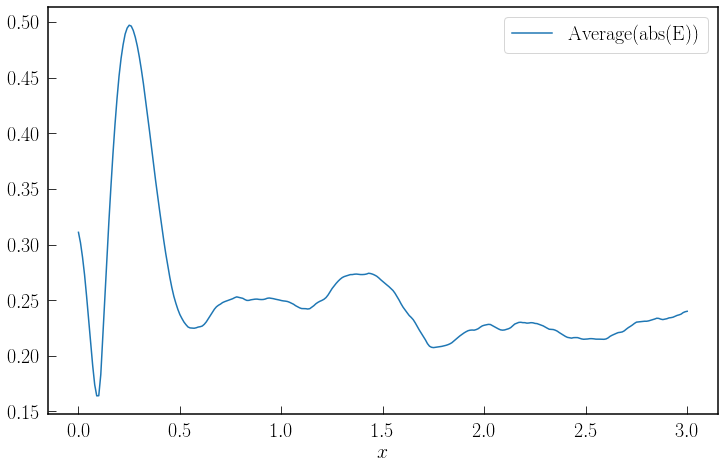

In [15]:
temp = np.linspace(0, time[-1], len(Ex_all_times))
pl.plot( temp, Ex_all_times , label = r'$\mathrm{Average(abs(E))}$')
pl.xlabel('$x$')
pl.legend()
pl.show()
# pl.savefig('AbsE.png')
pl.clf()

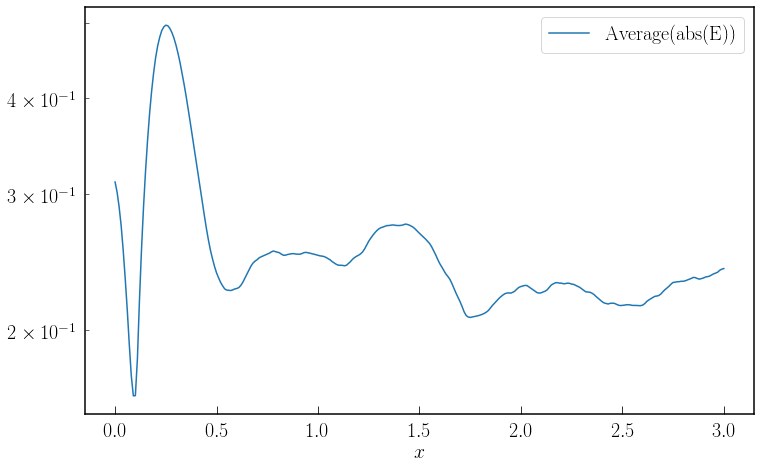

In [16]:
pl.semilogy(temp, Ex_all_times ,label = r'$\mathrm{Average(abs(E))}$')
pl.legend()
pl.xlabel('$x$')
pl.show()
# pl.savefig('AbsE_semilogy.png')
pl.clf()

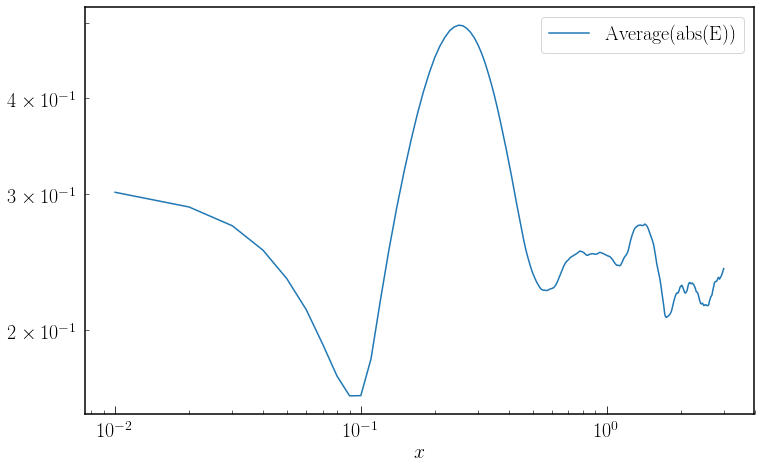

In [17]:
pl.loglog(temp, Ex_all_times ,label = r'$\mathrm{Average(abs(E))}$')
pl.legend()
pl.xlabel('$x$')
pl.show()
# pl.savefig('AbsE_semilogy.png')
pl.clf()

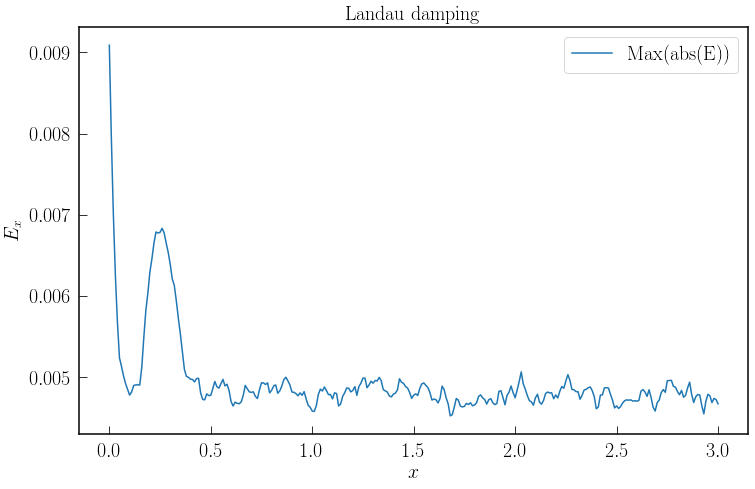

In [18]:
temp = np.linspace(0, time[-1], len(Ex_all_times))
pl.plot( temp, Ex_max , label = r'$\mathrm{Max(abs(E))}$')
pl.title('$\mathrm{Landau\;damping}$')
pl.xlabel('$x$')
pl.ylabel('$E_{x}$')
pl.legend()
pl.show()
# pl.savefig('MaxE.png')
pl.clf()

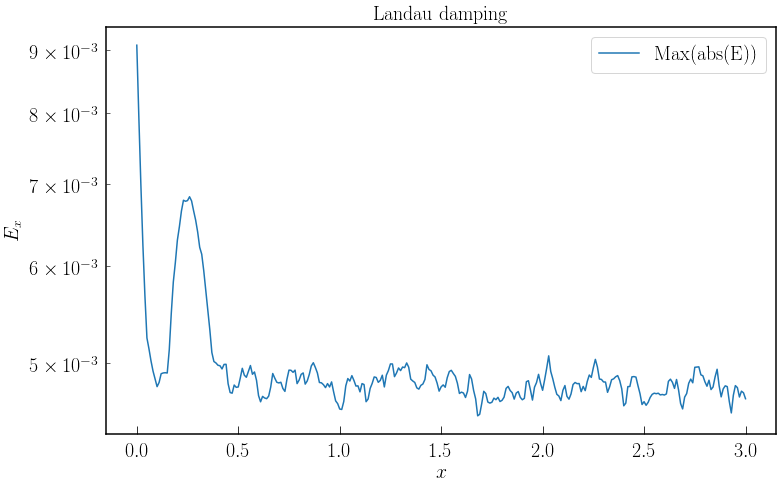

In [19]:
pl.semilogy(temp, Ex_max ,label = r'$\mathrm{Max(abs(E))}$')
pl.legend()
pl.title('$\mathrm{Landau\;damping}$')
pl.xlabel('$x$')
pl.ylabel('$E_{x}$')
pl.show()
# pl.savefig('MaxE_semilogy.png')
pl.clf()

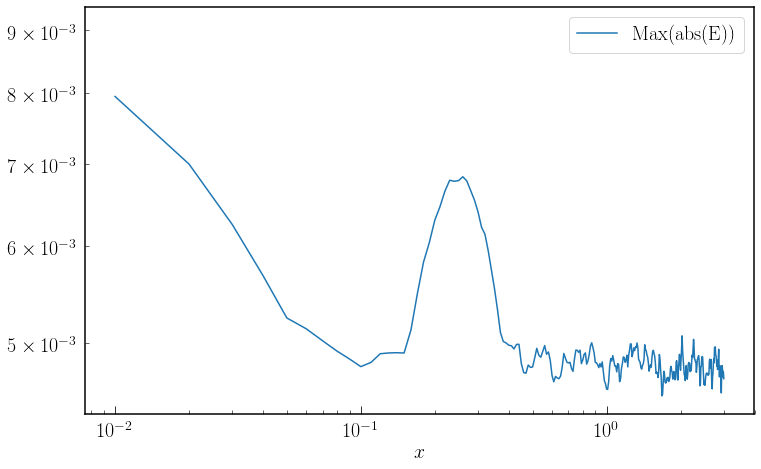

In [20]:
pl.loglog(temp, Ex_max ,label = r'$\mathrm{Max(abs(E))}$')
pl.legend()
pl.xlabel('$x$')
pl.show()
# pl.savefig('MaxE_semilogy.png')
pl.clf()

In [21]:
# # cloud_charge_deposition test
# charge = 1
# x_grid = np.array([0, 0.2, 0.4, 0.6, 0.8, 1.0])
# x = np.array([0.9])
# zone_x = np.array([4])
# frac_x = np.array([0.5])
# print(cloud_charge_deposition(charge, zone_x, frac_x, x_grid))

In [22]:
# # # FFT test

# rho_size = 200
# x = np.linspace(0, 1, rho_size )

# A = 0.1
# rho_0 = 0
# rho =  rho_0 + A * np.cos(2 * np.pi * x)
# dx = x[1] - x[0]

# V, E = fft_poisson(rho, dx)
# print('max(V)', max(V))
# # pl.plot(x, V,'--',lw = 3,label = '$V$')
# # pl.plot(x, ff.ifft(ff.fft(rho)), label = 'ifft(fft(rho))')
# # pl.plot(x, rho, label = r'$\rho$')
# # pl.plot(x, np.cos(2*np.pi*x)/(4 * np.pi**2), label= '$\mathrm{Analytical\;V}$')
# pl.plot(x, E, label = '$E_{x}$')
# pl.plot(x, A * np.sin(2 * np.pi * x)/(2 * np.pi), label = '$E_{x}\;analytical$')
# # pl.ylim(0,1)
# pl.legend()
# pl.show()
# pl.clf()